In [1]:
!pip install monai
!pip install torchmetrics
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [89]:
import os
import pickle
import segmentation_models_pytorch as smp
from monai.data import DataLoader, Dataset
from monai.utils import set_determinism
import torch
from torchmetrics import JaccardIndex
from tqdm import tqdm
from transformers import SegformerConfig, SegformerForSemanticSegmentation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')


In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
root_dir = "/content/drive/MyDrive/"
root_dir = os.path.join(root_dir, "ISLES-2022")
os.path.exists(root_dir)

True

In [7]:
# import custom model
from custom_model import CustomModel

### Load preprocessed data

In [6]:
# make sure those files exist before running this cell
with open(os.path.join(root_dir, 'kfold_splits.pkl'), 'rb') as f:
    folds = pickle.load(f)
with open(os.path.join(root_dir, 'test_set.pkl'), 'rb') as f:
    test_set = pickle.load(f)


In [ ]:
# gpu = "cuda"
# loss = "Jaccard"
# model_type = "resnet"

In [ ]:

# x = torch.randn(1, 3, 128, 128)
# model = CustomModel(
#         channels = [64, 128, 256, 512],
#         scale = [4, 2, 2, 2],
#         num_blocks = [2, 2, 2, 2],
#         num_heads = [2, 4, 8, 16],
#         mlp_hidden = [256, 512, 1024, 2048],
#         dropout = 0.0,                     # change to dropout rate=0.2
#         decoder_hidden = 256,
#         attention=True, # whether to use attention gate
#     )
# l =model.encoder(x)
# for i in range(len(l)):
#     print(l[i].shape)
# l.reverse()
# model.decoder(l).shape


torch.Size([1, 64, 32, 32])
torch.Size([1, 128, 16, 16])
torch.Size([1, 256, 8, 8])
torch.Size([1, 512, 4, 4])


torch.Size([1, 256, 64, 64])

In [ ]:
# if gpu == "cuda":
#     device = torch.device("cuda:0")

# if loss == "Dice":
#     loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)
# elif loss == "Jaccard":
#     loss_function = smp.losses.JaccardLoss(mode="binary", from_logits=False)

# metric = JaccardIndex(task="binary").to(device)

### Define training function

In [46]:
def get_model(model_type, device, attention_gate_flag=False):
    if model_type == "resnet":
        # Create the UNet model with the specified backbone
        model = smp.Unet(
            encoder_name="resnet34",
            in_channels=3,
            classes=1,
            activation="sigmoid",
            encoder_weights=None
        ).to(device)
    elif model_type == "unet":
        model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32, pretrained=False).to(device)
    elif model_type == "segformer":
        config = SegformerConfig(num_labels=1)
        model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512", num_labels=1, ignore_mismatched_sizes=True).to(device)
    elif model_type == "custom":
        model = CustomModel(
            channels = [64, 128, 256, 512],
            scale = [4, 2, 2, 2],
            num_blocks = [2, 2, 2, 2],
            num_heads = [2, 4, 8, 16],
            mlp_hidden = [256, 512, 1024, 2048],
            dropout = 0.2,                     # change to dropout rate=0.2
            decoder_hidden = 256,
            attention=attention_gate_flag, # whether to use attention gate
        ).to(device)

    return model


In [47]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    # trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of parameters: {total_params}")
    # print(f"Number of trainable parameters: {trainable_params}")
    return total_params
# count_parameters(model)

In [48]:
def add_model_par(df_model_par, model_type, parameters_num):
    """
    df_model_par: dataframe to save model parameters
    model_type: resnet, unet, segformer, custom
    parameters_num: number of parameters
    """
    next_index = len(df_model_par)
    df_model_par.loc[next_index] = [model_type, parameters_num]

In [49]:
def train_model(model_type, df_model_par, out_dir, loss_function, metric, device, lr=1e-4, attention_gate_flag=False):
    """
    model_type: resnet, unet, segformer, custom
    df_model_par: dataframe to save model parameters size
    out_dir: root directory of the dataset
    loss_function: loss function to evaluate the model, Dice or Jaccard
    metric: metric to evaluate the model, JaccardIndex(IoU) or  Dice
    device: device to train the model
    lr: learning rate
    attention_gate_flag: whether to use attention gate in custom model
    """


    model = get_model(model_type, device, attention_gate_flag=attention_gate_flag)
    add_model_par(df_model_par, model_type, count_parameters(model))



    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

    # use amp to accelerate training
    scaler = torch.cuda.amp.GradScaler()
    # enable cuDNN benchmark
    torch.backends.cudnn.benchmark = True

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    num_CV = 5
    max_epochs = 100
    epoch_per_CV = max_epochs // num_CV

    for i in range(num_CV):

        print("-" * 10)
        print(f"Fold {i}")
        train_ds = folds[i]["train"]
        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
        val_ds = folds[i]["val"]
        val_loader = DataLoader(val_ds, batch_size=8, num_workers=4)

        if i < num_CV - 1:
            start_epoch = i * epoch_per_CV
            end_epoch = (i + 1) * epoch_per_CV
        else:
            start_epoch = i * epoch_per_CV
            end_epoch = max_epochs

        for epoch in range(start_epoch, end_epoch):
            print("-" * 10)
            print(f"epoch {epoch + 1}/{max_epochs}")

            # Training
            model.train()
            epoch_loss = 0
            step = 0

            for batch_data in tqdm(train_loader, desc="Training"):
                step += 1
                inputs, labels = (
                    batch_data["image"].to(device),
                    batch_data["label"].to(device),
                )

                optimizer.zero_grad()

                with torch.cuda.amp.autocast():
                    inputs.to(torch.float32)
                    outputs = model(inputs)
                    if model_type == "segformer":
                        outputs = torch.nn.functional.sigmoid(torch.nn.functional.interpolate(outputs.logits,128,mode="bilinear",align_corners=False))
                    loss = loss_function(outputs, labels)

                if torch.isnan(loss) or torch.isnan(torch.flatten(outputs)).any().item():
                    print(outputs)
                    print(torch.isnan(torch.flatten(outputs)).any())
                    print(labels)
                    print(loss)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                epoch_loss += loss.item()

            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            # Validation
            if (epoch + 1) % val_interval == 0:
                model.eval()
                val_iou = 0.0
                num_batches = len(val_loader)

                with torch.no_grad():
                    for val_data in tqdm(val_loader, desc="Validation"):
                        val_inputs, val_labels = (
                            val_data["image"].to(device),
                            val_data["label"].to(device),
                        )

                        val_outputs = model(val_inputs)
                        if model_type == "segformer":
                            val_outputs = torch.nn.functional.sigmoid(torch.nn.functional.interpolate(val_outputs.logits,128,mode="bilinear",align_corners=False))

                        # Calculate IoU
                        iou = metric(val_outputs, val_labels)
                        val_iou += iou.item()

                # Calculate average IoU across all batches
                average_val_iou = val_iou / num_batches
                metric_values.append(average_val_iou)

                if average_val_iou > best_metric:
                    best_metric = average_val_iou
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(out_dir, "best_metric_model.pth"))
                    print("saved new best metric model")

                print(
                    f"current epoch: {epoch + 1} current mean IoU: {average_val_iou:.4f}"
                    f"\nbest mean IoU: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
    return epoch_loss_values, metric_values



In [31]:
def plot_train_curve(epoch_loss_values, metric_values, model_type, out_dir):

    epoch_loss_array = np.array(epoch_loss_values)
    metric_array = np.array(metric_values)
    np.savetxt(os.path.join(out_dir, 'epoch_loss_array.csv'), epoch_loss_array, delimiter=',')
    np.savetxt(os.path.join(out_dir, 'metric_array.csv'), metric_array, delimiter=',')


    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"{model_type} Epoch Average Loss")
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.plot(x, y)
    plt.subplot(1, 2, 2)
    plt.title(f"{model_type} Val Mean IoU ")
    x = [2 * (i + 1) for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel("epoch")
    plt.plot(x, y)
    plt.savefig(os.path.join(out_dir, "train_curve.png"))
    plt.show()

# plot_train_curve(epoch_loss_values, metric_values, out_dir)




### Training

In [32]:
gpu = "cuda"
loss = "Jaccard"

In [33]:
if gpu == "cuda":
    device = torch.device("cuda:0")

if loss == "Dice":
    loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)
elif loss == "Jaccard":
    loss_function = smp.losses.JaccardLoss(mode="binary", from_logits=False)

metric = JaccardIndex(task="binary").to(device)

In [34]:
loss_function, metric

(JaccardLoss(), BinaryJaccardIndex())

In [35]:
# dataframe to save model parameters
df_model_par = pd.DataFrame(columns=['model_type', 'parameters_num'])
print(root_dir)
print(device)

/content/drive/MyDrive/ISLES-2022
cuda:0


In [57]:
model_list = ["resnet", "unet", "segformer", "custom"]
# model_list = ["unet"]


In [58]:
set_determinism(0)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip


Total number of parameters: 7763041
----------
Fold 0
----------
epoch 1/100


Training:   0%|          | 0/97 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 97/97 [00:05<00:00, 17.45it/s]


epoch 1 average loss: 0.9773
----------
epoch 2/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.12it/s]


epoch 2 average loss: 0.9729


Validation: 100%|██████████| 97/97 [00:02<00:00, 45.18it/s]


saved new best metric model
current epoch: 2 current mean IoU: 0.1533
best mean IoU: 0.1533 at epoch: 2
----------
epoch 3/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.64it/s]


epoch 3 average loss: 0.9705
----------
epoch 4/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.16it/s]


epoch 4 average loss: 0.9682


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.29it/s]


saved new best metric model
current epoch: 4 current mean IoU: 0.4030
best mean IoU: 0.4030 at epoch: 4
----------
epoch 5/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.85it/s]


epoch 5 average loss: 0.9651
----------
epoch 6/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.59it/s]


epoch 6 average loss: 0.9616


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.39it/s]


saved new best metric model
current epoch: 6 current mean IoU: 0.4854
best mean IoU: 0.4854 at epoch: 6
----------
epoch 7/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.90it/s]


epoch 7 average loss: 0.9576
----------
epoch 8/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.03it/s]


epoch 8 average loss: 0.9523


Validation: 100%|██████████| 97/97 [00:01<00:00, 53.59it/s]


current epoch: 8 current mean IoU: 0.4755
best mean IoU: 0.4854 at epoch: 6
----------
epoch 9/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.42it/s]


epoch 9 average loss: 0.9464
----------
epoch 10/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.68it/s]


epoch 10 average loss: 0.9387


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.93it/s]


current epoch: 10 current mean IoU: 0.3261
best mean IoU: 0.4854 at epoch: 6
----------
epoch 11/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.48it/s]


epoch 11 average loss: 0.9279
----------
epoch 12/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.43it/s]


epoch 12 average loss: 0.9164


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.37it/s]


saved new best metric model
current epoch: 12 current mean IoU: 0.5520
best mean IoU: 0.5520 at epoch: 12
----------
epoch 13/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.19it/s]


epoch 13 average loss: 0.8980
----------
epoch 14/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.88it/s]


epoch 14 average loss: 0.8747


Validation: 100%|██████████| 97/97 [00:01<00:00, 53.71it/s]


current epoch: 14 current mean IoU: 0.5182
best mean IoU: 0.5520 at epoch: 12
----------
epoch 15/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.21it/s]


epoch 15 average loss: 0.8450
----------
epoch 16/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.47it/s]


epoch 16 average loss: 0.8098


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.61it/s]


saved new best metric model
current epoch: 16 current mean IoU: 0.6931
best mean IoU: 0.6931 at epoch: 16
----------
epoch 17/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.93it/s]


epoch 17 average loss: 0.7678
----------
epoch 18/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.45it/s]


epoch 18 average loss: 0.7163


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.16it/s]


current epoch: 18 current mean IoU: 0.6812
best mean IoU: 0.6931 at epoch: 16
----------
epoch 19/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.93it/s]


epoch 19 average loss: 0.6641
----------
epoch 20/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.12it/s]


epoch 20 average loss: 0.6051


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.26it/s]


saved new best metric model
current epoch: 20 current mean IoU: 0.6972
best mean IoU: 0.6972 at epoch: 20
----------
Fold 1
----------
epoch 21/100


Training: 100%|██████████| 97/97 [00:04<00:00, 20.11it/s]


epoch 21 average loss: 0.5554
----------
epoch 22/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.42it/s]


epoch 22 average loss: 0.4981


Validation: 100%|██████████| 97/97 [00:02<00:00, 48.16it/s]


saved new best metric model
current epoch: 22 current mean IoU: 0.7522
best mean IoU: 0.7522 at epoch: 22
----------
epoch 23/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.55it/s]


epoch 23 average loss: 0.4480
----------
epoch 24/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.20it/s]


epoch 24 average loss: 0.4136


Validation: 100%|██████████| 97/97 [00:01<00:00, 52.86it/s]


saved new best metric model
current epoch: 24 current mean IoU: 0.7671
best mean IoU: 0.7671 at epoch: 24
----------
epoch 25/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.18it/s]


epoch 25 average loss: 0.3769
----------
epoch 26/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.33it/s]


epoch 26 average loss: 0.3482


Validation: 100%|██████████| 97/97 [00:01<00:00, 52.91it/s]


saved new best metric model
current epoch: 26 current mean IoU: 0.7802
best mean IoU: 0.7802 at epoch: 26
----------
epoch 27/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.20it/s]


epoch 27 average loss: 0.3229
----------
epoch 28/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.42it/s]


epoch 28 average loss: 0.2979


Validation: 100%|██████████| 97/97 [00:01<00:00, 53.47it/s]


current epoch: 28 current mean IoU: 0.7704
best mean IoU: 0.7802 at epoch: 26
----------
epoch 29/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.11it/s]


epoch 29 average loss: 0.2828
----------
epoch 30/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.37it/s]


epoch 30 average loss: 0.2659


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.21it/s]


current epoch: 30 current mean IoU: 0.7750
best mean IoU: 0.7802 at epoch: 26
----------
epoch 31/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.97it/s]


epoch 31 average loss: 0.2475
----------
epoch 32/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.28it/s]


epoch 32 average loss: 0.2398


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.66it/s]


saved new best metric model
current epoch: 32 current mean IoU: 0.7880
best mean IoU: 0.7880 at epoch: 32
----------
epoch 33/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.37it/s]


epoch 33 average loss: 0.2263
----------
epoch 34/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.35it/s]


epoch 34 average loss: 0.2164


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.03it/s]


current epoch: 34 current mean IoU: 0.7787
best mean IoU: 0.7880 at epoch: 32
----------
epoch 35/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.15it/s]


epoch 35 average loss: 0.2066
----------
epoch 36/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.09it/s]


epoch 36 average loss: 0.1998


Validation: 100%|██████████| 97/97 [00:01<00:00, 52.92it/s]


saved new best metric model
current epoch: 36 current mean IoU: 0.7924
best mean IoU: 0.7924 at epoch: 36
----------
epoch 37/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.24it/s]


epoch 37 average loss: 0.1962
----------
epoch 38/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.45it/s]


epoch 38 average loss: 0.1896


Validation: 100%|██████████| 97/97 [00:01<00:00, 53.38it/s]


saved new best metric model
current epoch: 38 current mean IoU: 0.7976
best mean IoU: 0.7976 at epoch: 38
----------
epoch 39/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.11it/s]


epoch 39 average loss: 0.1849
----------
epoch 40/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.09it/s]


epoch 40 average loss: 0.1753


Validation: 100%|██████████| 97/97 [00:01<00:00, 52.97it/s]


current epoch: 40 current mean IoU: 0.7778
best mean IoU: 0.7976 at epoch: 38
----------
Fold 2
----------
epoch 41/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.63it/s]


epoch 41 average loss: 0.1885
----------
epoch 42/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.48it/s]


epoch 42 average loss: 0.1888


Validation: 100%|██████████| 97/97 [00:01<00:00, 53.11it/s]


saved new best metric model
current epoch: 42 current mean IoU: 0.8443
best mean IoU: 0.8443 at epoch: 42
----------
epoch 43/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.70it/s]


epoch 43 average loss: 0.1787
----------
epoch 44/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.34it/s]


epoch 44 average loss: 0.1724


Validation: 100%|██████████| 97/97 [00:01<00:00, 53.93it/s]


current epoch: 44 current mean IoU: 0.8435
best mean IoU: 0.8443 at epoch: 42
----------
epoch 45/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.11it/s]


epoch 45 average loss: 0.1649
----------
epoch 46/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.80it/s]


epoch 46 average loss: 0.1646


Validation: 100%|██████████| 97/97 [00:01<00:00, 56.53it/s]


saved new best metric model
current epoch: 46 current mean IoU: 0.8463
best mean IoU: 0.8463 at epoch: 46
----------
epoch 47/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.30it/s]


epoch 47 average loss: 0.1578
----------
epoch 48/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.43it/s]


epoch 48 average loss: 0.1572


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.26it/s]


current epoch: 48 current mean IoU: 0.8458
best mean IoU: 0.8463 at epoch: 46
----------
epoch 49/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.41it/s]


epoch 49 average loss: 0.1575
----------
epoch 50/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.14it/s]


epoch 50 average loss: 0.1498


Validation: 100%|██████████| 97/97 [00:01<00:00, 53.51it/s]


saved new best metric model
current epoch: 50 current mean IoU: 0.8483
best mean IoU: 0.8483 at epoch: 50
----------
epoch 51/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.06it/s]


epoch 51 average loss: 0.1502
----------
epoch 52/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.70it/s]


epoch 52 average loss: 0.1477


Validation: 100%|██████████| 97/97 [00:01<00:00, 53.72it/s]


current epoch: 52 current mean IoU: 0.8438
best mean IoU: 0.8483 at epoch: 50
----------
epoch 53/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.99it/s]


epoch 53 average loss: 0.1439
----------
epoch 54/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.24it/s]


epoch 54 average loss: 0.1416


Validation: 100%|██████████| 97/97 [00:01<00:00, 52.56it/s]


current epoch: 54 current mean IoU: 0.8452
best mean IoU: 0.8483 at epoch: 50
----------
epoch 55/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.12it/s]


epoch 55 average loss: 0.1405
----------
epoch 56/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.53it/s]


epoch 56 average loss: 0.1417


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.19it/s]


current epoch: 56 current mean IoU: 0.8381
best mean IoU: 0.8483 at epoch: 50
----------
epoch 57/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.68it/s]


epoch 57 average loss: 0.1404
----------
epoch 58/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.54it/s]


epoch 58 average loss: 0.1370


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.25it/s]


current epoch: 58 current mean IoU: 0.8423
best mean IoU: 0.8483 at epoch: 50
----------
epoch 59/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.00it/s]


epoch 59 average loss: 0.1329
----------
epoch 60/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.40it/s]


epoch 60 average loss: 0.1339


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.52it/s]


current epoch: 60 current mean IoU: 0.8380
best mean IoU: 0.8483 at epoch: 50
----------
Fold 3
----------
epoch 61/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.54it/s]


epoch 61 average loss: 0.1389
----------
epoch 62/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.99it/s]


epoch 62 average loss: 0.1350


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.20it/s]


saved new best metric model
current epoch: 62 current mean IoU: 0.8744
best mean IoU: 0.8744 at epoch: 62
----------
epoch 63/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.11it/s]


epoch 63 average loss: 0.1360
----------
epoch 64/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.12it/s]


epoch 64 average loss: 0.1320


Validation: 100%|██████████| 97/97 [00:01<00:00, 53.90it/s]


saved new best metric model
current epoch: 64 current mean IoU: 0.8805
best mean IoU: 0.8805 at epoch: 64
----------
epoch 65/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.27it/s]


epoch 65 average loss: 0.1313
----------
epoch 66/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.28it/s]


epoch 66 average loss: 0.1296


Validation: 100%|██████████| 97/97 [00:01<00:00, 52.21it/s]


current epoch: 66 current mean IoU: 0.8742
best mean IoU: 0.8805 at epoch: 64
----------
epoch 67/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.26it/s]


epoch 67 average loss: 0.1255
----------
epoch 68/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.42it/s]


epoch 68 average loss: 0.1232


Validation: 100%|██████████| 97/97 [00:01<00:00, 52.04it/s]


current epoch: 68 current mean IoU: 0.8765
best mean IoU: 0.8805 at epoch: 64
----------
epoch 69/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.90it/s]


epoch 69 average loss: 0.1271
----------
epoch 70/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.10it/s]


epoch 70 average loss: 0.1226


Validation: 100%|██████████| 97/97 [00:01<00:00, 53.95it/s]


current epoch: 70 current mean IoU: 0.8732
best mean IoU: 0.8805 at epoch: 64
----------
epoch 71/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.23it/s]


epoch 71 average loss: 0.1249
----------
epoch 72/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.55it/s]


epoch 72 average loss: 0.1190


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.83it/s]


current epoch: 72 current mean IoU: 0.8705
best mean IoU: 0.8805 at epoch: 64
----------
epoch 73/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.14it/s]


epoch 73 average loss: 0.1198
----------
epoch 74/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.77it/s]


epoch 74 average loss: 0.1215


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.87it/s]


current epoch: 74 current mean IoU: 0.8608
best mean IoU: 0.8805 at epoch: 64
----------
epoch 75/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.24it/s]


epoch 75 average loss: 0.1200
----------
epoch 76/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.82it/s]


epoch 76 average loss: 0.1184


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.92it/s]


current epoch: 76 current mean IoU: 0.8677
best mean IoU: 0.8805 at epoch: 64
----------
epoch 77/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.92it/s]


epoch 77 average loss: 0.1161
----------
epoch 78/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.38it/s]


epoch 78 average loss: 0.1157


Validation: 100%|██████████| 97/97 [00:01<00:00, 53.27it/s]


current epoch: 78 current mean IoU: 0.8744
best mean IoU: 0.8805 at epoch: 64
----------
epoch 79/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.06it/s]


epoch 79 average loss: 0.1132
----------
epoch 80/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.59it/s]


epoch 80 average loss: 0.1130


Validation: 100%|██████████| 97/97 [00:01<00:00, 53.75it/s]


current epoch: 80 current mean IoU: 0.8650
best mean IoU: 0.8805 at epoch: 64
----------
Fold 4
----------
epoch 81/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.46it/s]


epoch 81 average loss: 0.1215
----------
epoch 82/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.12it/s]


epoch 82 average loss: 0.1187


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.60it/s]


saved new best metric model
current epoch: 82 current mean IoU: 0.8996
best mean IoU: 0.8996 at epoch: 82
----------
epoch 83/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.11it/s]


epoch 83 average loss: 0.1176
----------
epoch 84/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.01it/s]


epoch 84 average loss: 0.1154


Validation: 100%|██████████| 97/97 [00:01<00:00, 51.26it/s]


current epoch: 84 current mean IoU: 0.8951
best mean IoU: 0.8996 at epoch: 82
----------
epoch 85/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.85it/s]


epoch 85 average loss: 0.1130
----------
epoch 86/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.53it/s]


epoch 86 average loss: 0.1173


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.92it/s]


current epoch: 86 current mean IoU: 0.8917
best mean IoU: 0.8996 at epoch: 82
----------
epoch 87/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.19it/s]


epoch 87 average loss: 0.1187
----------
epoch 88/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.54it/s]


epoch 88 average loss: 0.1156


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.25it/s]


current epoch: 88 current mean IoU: 0.8874
best mean IoU: 0.8996 at epoch: 82
----------
epoch 89/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.50it/s]


epoch 89 average loss: 0.1108
----------
epoch 90/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.17it/s]


epoch 90 average loss: 0.1110


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.76it/s]


current epoch: 90 current mean IoU: 0.8853
best mean IoU: 0.8996 at epoch: 82
----------
epoch 91/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.39it/s]


epoch 91 average loss: 0.1119
----------
epoch 92/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.94it/s]


epoch 92 average loss: 0.1105


Validation: 100%|██████████| 97/97 [00:01<00:00, 53.68it/s]


current epoch: 92 current mean IoU: 0.8890
best mean IoU: 0.8996 at epoch: 82
----------
epoch 93/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.88it/s]


epoch 93 average loss: 0.1068
----------
epoch 94/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.45it/s]


epoch 94 average loss: 0.1082


Validation: 100%|██████████| 97/97 [00:01<00:00, 51.35it/s]


current epoch: 94 current mean IoU: 0.8887
best mean IoU: 0.8996 at epoch: 82
----------
epoch 95/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.38it/s]


epoch 95 average loss: 0.1057
----------
epoch 96/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.97it/s]


epoch 96 average loss: 0.1048


Validation: 100%|██████████| 97/97 [00:01<00:00, 53.81it/s]


current epoch: 96 current mean IoU: 0.8938
best mean IoU: 0.8996 at epoch: 82
----------
epoch 97/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.69it/s]


epoch 97 average loss: 0.1039
----------
epoch 98/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.35it/s]


epoch 98 average loss: 0.1025


Validation: 100%|██████████| 97/97 [00:01<00:00, 55.21it/s]


current epoch: 98 current mean IoU: 0.8890
best mean IoU: 0.8996 at epoch: 82
----------
epoch 99/100


Training: 100%|██████████| 97/97 [00:04<00:00, 22.98it/s]


epoch 99 average loss: 0.1032
----------
epoch 100/100


Training: 100%|██████████| 97/97 [00:04<00:00, 23.05it/s]


epoch 100 average loss: 0.1013


Validation: 100%|██████████| 97/97 [00:01<00:00, 54.01it/s]


current epoch: 100 current mean IoU: 0.8800
best mean IoU: 0.8996 at epoch: 82


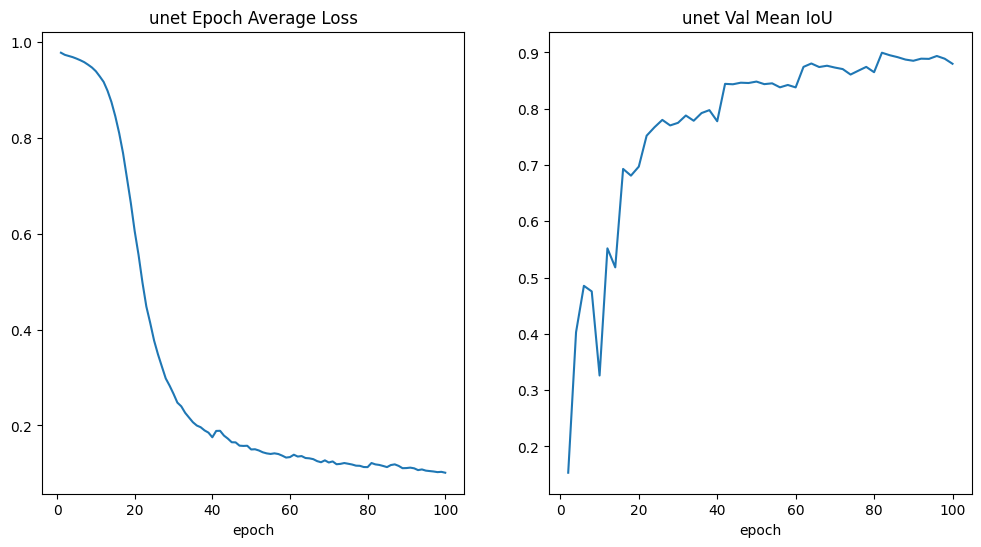

In [59]:
for model_type in model_list:
    os.makedirs(os.path.join(root_dir, model_type), exist_ok=True)
    out_dir = os.path.join(root_dir, model_type)
    loss_values, metric_values = train_model(model_type, df_model_par, out_dir, loss_function, metric, device, lr=1e-4, attention_gate_flag=True)
    plot_train_curve(loss_values, metric_values, model_type, out_dir)

Testing

In [51]:
test_loader = DataLoader(
    test_set, batch_size=8, num_workers=4
)
out_dir

'/content/drive/MyDrive/ISLES-2022/custom'

In [64]:
root_dir

'/content/drive/MyDrive/ISLES-2022'

In [65]:
model_list = ["resnet", "unet", "segformer", "custom"]

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


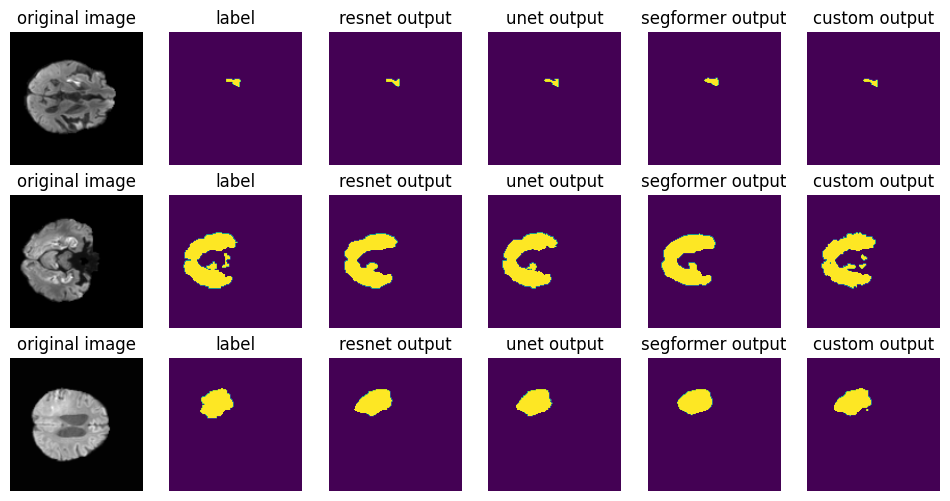

In [90]:
mean_test_metric = pd.DataFrame(columns=['model_tye', 'mean_test_iou'])
plt.figure("check", (12, 6))
for j in range(len(model_list)):
    model_type = model_list[j]
    model = get_model(model_type, device, attention_gate_flag=True)
    model.load_state_dict(torch.load(os.path.join(root_dir, model_type, "best_metric_model.pth")))
    model.eval()
    test_metric_values = []
    with torch.no_grad():
        for i, test_data in enumerate(test_loader):

            test_outputs = model(test_data["image"].to(device))
            test_labels = test_data["label"].to(device)
            if model_type == "segformer":
                test_outputs = torch.nn.functional.sigmoid(torch.nn.functional.interpolate(test_outputs.logits,128,mode="bilinear",align_corners=False))

            test_outputs = test_outputs.float() > 0.5
            iou = metric(test_outputs, test_labels)
            test_metric_values.append(iou.item())


            # for j in range(10):
            if i >= 30 and i < 33:
                k = i - 30
                if j == 0:
                    plt.subplot(3, 6, 1 + 6 * k)
                    plt.title("original image")
                    plt.axis("off")
                    plt.imshow(test_data["image"][5, 0, :, :], cmap="gray")
                    plt.subplot(3, 6, 2 + 6 * k)
                    plt.title("label")
                    plt.axis("off")
                    plt.imshow(test_data["label"][5, 0, :, :])
                plt.subplot(3, 6, j + 3 + 6 * k)
                plt.title(f"{model_type} output")
                plt.axis("off")

                plt.imshow(test_outputs.detach().cpu()[5, 0, :, :])
    mean_test_metric.loc[j] = [model_type, sum(test_metric_values) / len(test_metric_values)]
plt.savefig(os.path.join(root_dir, f"model_comparison.png"))
plt.show()


In [91]:
mean_test_metric

,model_tye,mean_test_iou
0,resnet,0.772555
1,unet,0.783419
2,segformer,0.698742
3,custom,0.764529


In [93]:
df_model_par['parameters_num_millions'] = df_model_par['parameters_num'] / 1_000_000

In [99]:
df_model_par

,model_type,parameters_num,parameters_num_millions
0,resnet,24436369,24.436369
1,unet,7763041,7.763041
2,segformer,3714401,3.714401
3,custom,51145311,51.145311


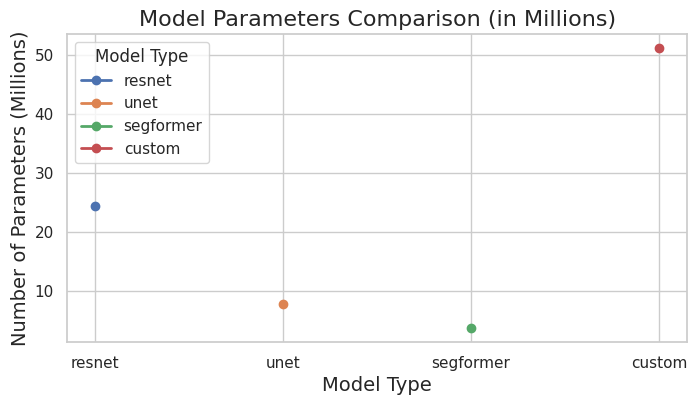

In [102]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
for idx, row in df_model_par.iterrows():
    plt.plot([row['model_type']], [row['parameters_num_millions']], label=row['model_type'], marker='o', linestyle='-', linewidth=2)
plt.title('Model Parameters Comparison (in Millions)', fontsize=16)
plt.xlabel('Model Type', fontsize=14)
plt.ylabel('Number of Parameters (Millions)', fontsize=14)
plt.legend(title='Model Type')
plt.savefig(os.path.join(root_dir, "model_parameters_line_plot.png"), dpi=300)
plt.show()